In [28]:
import pandas as pd
import numpy as np
import gc
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from helpers.funcs import resample, single_ts_split, timeseries_train_test_split as TSSplit, fit_model_cv
import matplotlib.pyplot as plt
%matplotlib inline
NB_SEED = 123123

In [2]:
tscv = TimeSeriesSplit(n_splits=5)

In [3]:
def setindexdatetime(df, index_col):
    df[index_col] = pd.to_datetime(df[index_col])
    df.set_index(index_col, inplace=True)
    df = df.astype(np.float)
    return df

In [4]:
tr = setindexdatetime(pd.read_csv('valids/v_ready_iqr_tr.csv'),'Timestamp')
ts = setindexdatetime(pd.read_csv('valids/v_ready_iqr_ts.csv'),'Timestamp')

In [5]:
tr.index.freq = '15T'

In [6]:
ts = resample(ts)

/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:39: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  tseries.index[0], pd.tslib.Timestamp), 'Object must have a datetime-like index.'
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:73: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  tseries = tseries.resample(short_rate, how='mean').interpolate()
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:76: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ffill()
  tseries = tseries.resample(rate, how='ffill')


In [7]:
tr_Target = tr.Target.copy()

In [8]:
######## ADDING TIME RELATED FEATURES TO DATA #########
#Weekday, Hour, Month
tr['Date'] = tr.index.values
tr['Weekday'] = tr.Date.apply(lambda x: x.weekday())
tr['Hour'] = tr.Date.apply(lambda x: x.hour)
tr['Month'] = tr.Date.apply(lambda x: x.month)
#tr['DayCnt'] = tr.Date.apply(lambda x: x.toordinal())

ts['Date'] = ts.index.values
ts['Weekday'] = ts.Date.apply(lambda x: x.weekday())
ts['Hour'] = ts.Date.apply(lambda x: x.hour)
ts['Month'] = ts.Date.apply(lambda x: x.month)
#ts['DayCnt'] = ts.Date.apply(lambda x: x.toordinal())

tr = pd.get_dummies(tr, columns=["Month","Hour","Weekday"])
ts = pd.get_dummies(ts, columns=["Month","Hour","Weekday"])
tr.drop('Date',1,inplace=True)
ts.drop('Date',1,inplace=True)

In [9]:
from sklearn.preprocessing import MinMaxScaler
trsc = MinMaxScaler()
tssc = MinMaxScaler()
tr_nf = tr.loc[:,tr.dtypes!="float64"]
ts_nf = ts.loc[:,ts.dtypes!="float64"]
tr_cont = tr.loc[:,tr.dtypes=="float64"].drop('Target',1)
tr_cont_names = tr_cont.columns.values
tr_cont_idx = tr_cont.index
ts_cont = ts.loc[:,ts.dtypes=="float64"]
ts_cont_names = ts_cont.columns.values
ts_cont_idx = ts_cont.index
tr_cont = trsc.fit_transform(tr_cont)
ts_cont = tssc.fit_transform(ts_cont)
tr_cont = pd.DataFrame(tr_cont)
ts_cont = pd.DataFrame(ts_cont)
tr_cont.columns = tr_cont_names
ts_cont.columns = ts_cont_names
tr_cont.index = tr_cont_idx
ts_cont.index = ts_cont_idx

tr = tr_nf.join(tr_cont).join(tr_Target)
ts = ts_nf.join(ts_cont)

tr = tr.loc[:,tr.dtypes!="float64"].join(tr_Target)
ts = ts.loc[:,ts.dtypes!="float64"]

In [10]:
x_tr, x_ts, y_tr, y_ts = TSSplit(tr.drop('Target',1),tr.Target, test_size=0.30)

In [11]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [82]:
xg = XGBRegressor(booster="gblinear",
                  eta=0.001,
                 n_jobs=-1,
                 reg_lambda=0.5,
                 reg_alpha=0.5,
                 seed=NB_SEED) 

xg_t = XGBRegressor(eta=0.001,
                 min_child_weight=8,
                 subsample=0.9,
                 colsample_bytree=0.8,
                 silent=1,
                 max_depth=8,
                 seed=NB_SEED,
                 n_jobs=-1)
lr = LinearRegression(n_jobs=-1)

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [84]:
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [89]:
x_tr

,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,...,Hour_21,Hour_22,Hour_23,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-08-08 16:00:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-08-08 16:15:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-08-08 16:30:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-08-08 16:45:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-08-08 17:00:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-08-08 17:15:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-08-08 17:30:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-08-08 17:45:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-08-08 18:00:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [85]:
mdls = fit_model_cv(xg,x_tr.values,y_tr.values)
y_pred_val = np.zeros((y_ts.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [86]:
y_pred = np.zeros((y_ts.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts.values)
y_pred = y_pred.mean(axis=1)

In [87]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [88]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 32.7592652540947 test: 43.8347383252279
RMSE train: 5.7235710228925 test: 6.620780794228722
MAE train: 4.574746569037424 test: 5.288124022041363
R2 train: -0.21212071330869042 test: -0.22871570708655753


In [79]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

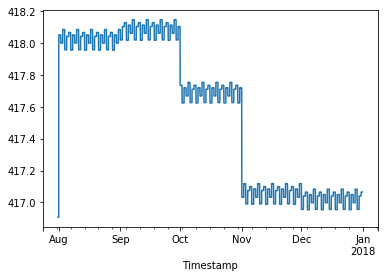

In [80]:
y_pred.plot()

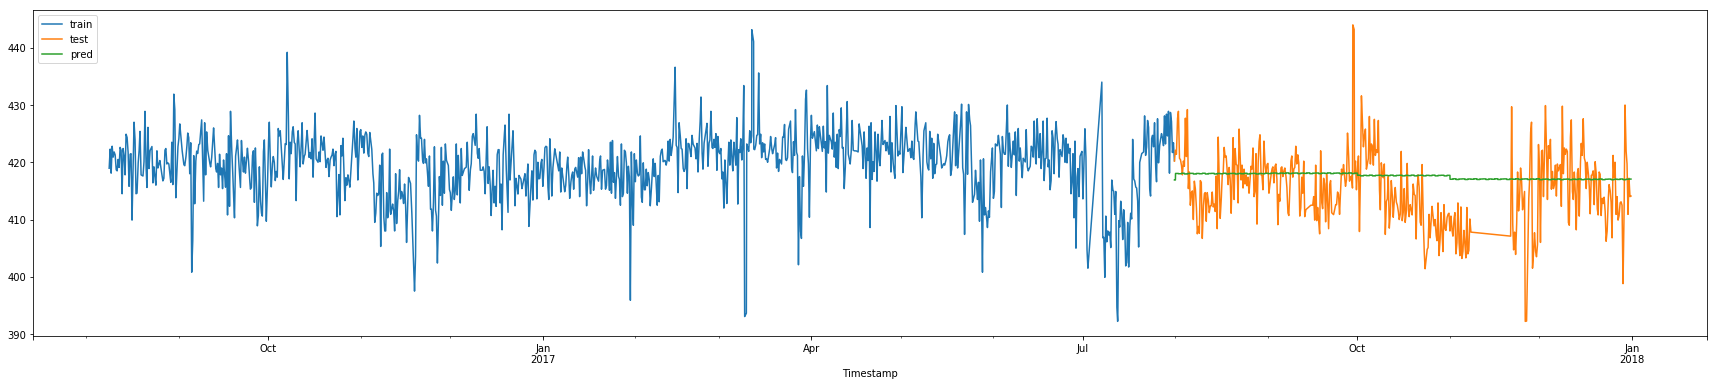

In [81]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [22]:
del mdls;gc.collect()

19

In [23]:
mdls = fit_model_cv(xg_t,x_tr.values,y_tr.values)
y_pred_val = np.zeros((y_ts.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [24]:
y_pred = np.zeros((y_ts.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts.values)
y_pred = y_pred.mean(axis=1)

In [25]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [26]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 22.810663561250255 test: 56.3047992370864
RMSE train: 4.776051042571703 test: 7.503652393140716
MAE train: 3.4269523334329173 test: 6.035558554325833
R2 train: 0.1559860218949437 test: -0.5782594775328478


In [27]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

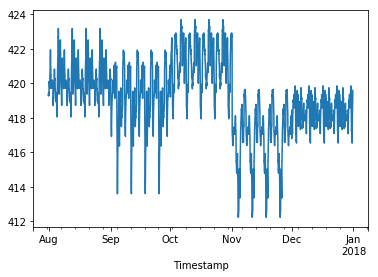

In [28]:
y_pred.plot()

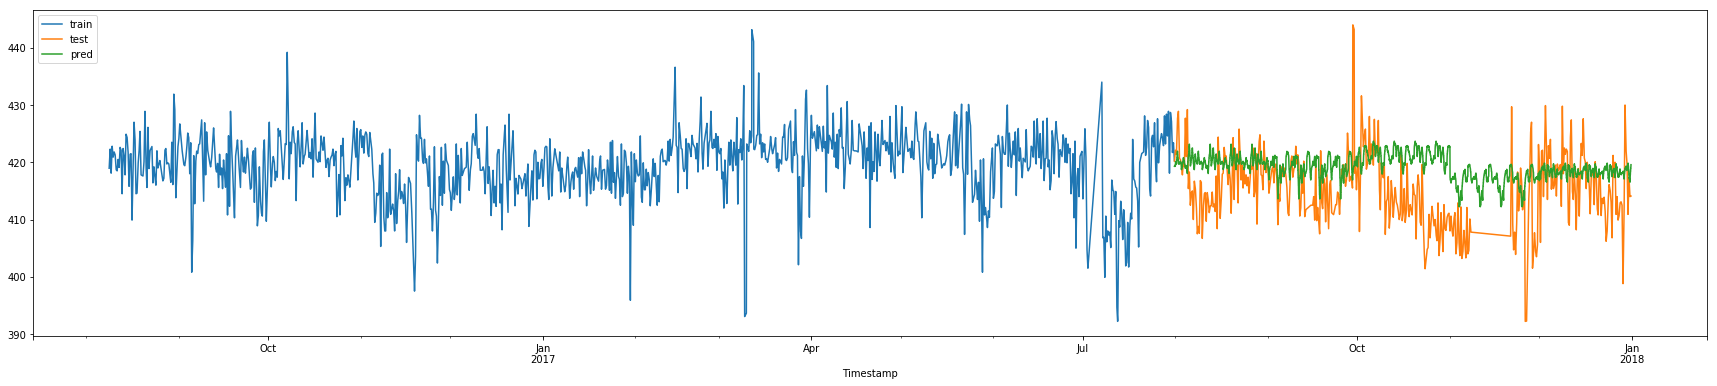

In [29]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [30]:
del mdls;gc.collect()

12

In [31]:
mdls = fit_model_cv(lr,x_tr.values,y_tr.values)
y_pred_val = np.zeros((y_ts.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [32]:
y_pred = np.zeros((y_ts.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts.values)
y_pred = y_pred.mean(axis=1)

In [33]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [34]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 2.4649322430372405e+25 test: 6.562310527417356e+24
RMSE train: 4964808398153.186 test: 2561700709961.52
MAE train: 3519258705347.8286 test: 1593548150185.1355
R2 train: -9.120459221271561e+23 test: -1.839457546202942e+23


In [35]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

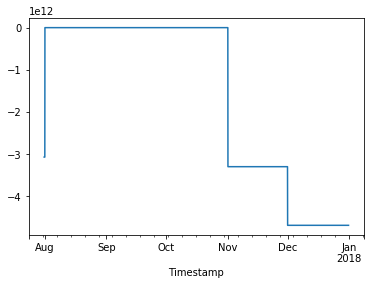

In [36]:
y_pred.plot()

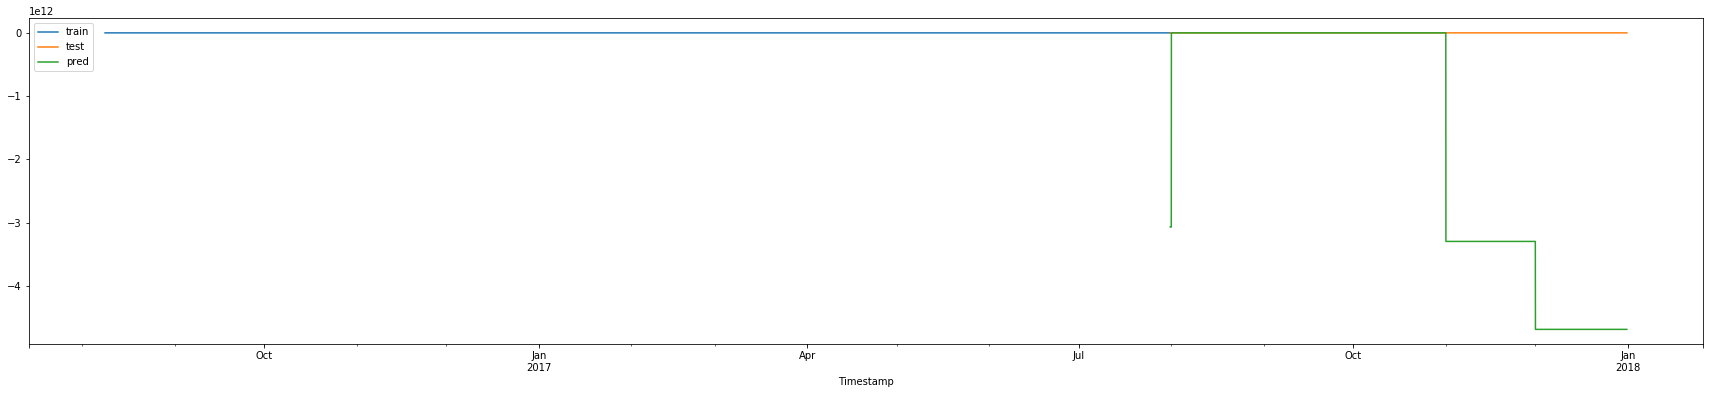

In [37]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [38]:
#Bayesian optimization for XGBLinear

In [39]:
print(xg.get_params())

{'base_score': 0.5, 'booster': 'gblinear', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'scale_pos_weight': 1, 'seed': 123123, 'silent': True, 'subsample': 1, 'eta': 0.001}


In [40]:
xg = XGBRegressor(booster="gblinear",
                  eta=0.001,
                 n_jobs=-1,
                 reg_lambda=0.5,
                 reg_alpha=0.5) 

In [41]:
import numpy as np
def score_cv(mdl,X,y,tscv):
    r2_l_tr = list()
    r2_l_val = list()
    for tr_i, ho_i in tscv.split(X):
        mdl.fit(X[tr_i],y[tr_i])
        y_pred = mdl.predict(X[ho_i])
        y_pred_tr = mdl.predict(X[tr_i])
        r2_l_val.append(r2_score(y[ho_i],y_pred))
        r2_l_tr.append(r2_score(y[tr_i],y_pred_tr))
    rtr = np.mean(r2_l_val)*0.7 + np.mean(r2_l_tr)*0.3
    return rtr

In [42]:
from bayes_opt import BayesianOptimization
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [68]:
def XGB_CV(eta,
           max_depth,
           min_child_weight,
           max_delta_step,
           colsample_bylevel,
           colsample_bytree,
           gamma
           #reg_lambda,
           #reg_alpha
          ):
    xgb = XGBRegressor(booster='gblinear',
                      max_depth=int(max_depth),
                      min_child_weight=int(min_child_weight),
                      max_delta_step=int(max_delta_step),
                      n_estimators=int(1000),
                      colsample_bylevel= float(colsample_bylevel),
                      colsample_bytree= float(colsample_bytree),
                       gamma=int(gamma),
                       #reg_lambda=float(reg_lambda),
                       #reg_alpha=float(reg_alpha),
                        seed=NB_SEED,
                       n_jobs=-1
                      )
    tscv = TimeSeriesSplit(n_splits=5)
    scr = score_cv(xgb, x_tr.values, y_tr.values, tscv)
    return scr

In [69]:
bds = {
    'eta':(0.001,0.5),
    'max_depth':(6,10),
    'min_child_weight':(1,10),
    'max_delta_step':(1,10),
    'colsample_bylevel':(0,1),
    'colsample_bytree':(0,1),
    'gamma':(0,20)
}

In [70]:
print(bds)

{'eta': (0.001, 0.5), 'max_depth': (6, 10), 'min_child_weight': (1, 10), 'max_delta_step': (1, 10), 'colsample_bylevel': (0, 1), 'colsample_bytree': (0, 1), 'gamma': (0, 20)}


In [71]:
xgbo = BayesianOptimization(XGB_CV, bds)

In [72]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    xgbo.maximize(init_points=10,
                 n_iter=150)

|   iter    |  target   | colsam... | colsam... |    eta    |   gamma   | max_de... | max_depth | min_ch... |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.07102  |  0.1617   |  0.2961   |  0.2396   |  3.233    |  7.513    |  8.625    |  6.509    |
|  2        | -0.07102  |  0.012    |  0.03582  |  0.04654  |  2.98     |  2.526    |  7.358    |  7.564    |
|  3        | -0.07102  |  0.4593   |  0.5313   |  0.2119   |  6.315    |  5.145    |  6.698    |  4.447    |
|  4        | -0.07102  |  0.4805   |  0.8502   |  0.4636   |  4.058    |  4.344    |  8.195    |  9.608    |
|  5        | -0.07102  |  0.449    |  0.1215   |  0.4688   |  10.96    |  6.095    |  8.377    |  6.093    |
|  6        | -0.07102  |  0.6007   |  0.09151  |  0.1288   |  16.14    |  7.803    |  9.848    |  6.651    |
|  7        | -0.07102  |  0.5049   |  0.2589   |  0.4537   |  15.91    |  5.641    |  7.429    |  3.816    |
|  8      

In [13]:
csl = 0.459267686685061
cst = 0.5313126202687283
eta = 0.21187356400699806
gm = int(6.314718408200612)
mds = int(5.145255898947115)
md = int(6.698173111909718)
mw = int(4.446943240987178)

In [97]:
print(csl)

0.459267686685061


In [98]:
print(cst)

0.5313126202687283


In [99]:
print(eta)

0.21187356400699806


In [100]:
print(gm)

6.314718408200612


In [101]:
print(mds)

5.145255898947115


In [102]:
print(md)

6.698173111909718


In [103]:
print(mw)

4.446943240987178


In [125]:
xgb_o = XGBRegressor(booster='gblinear',
                     eta=eta,
                      max_depth=int(md),
                      min_child_weight=int(mw),
                      max_delta_step=int(md),
                      n_estimators=int(1000),
                      colsample_bylevel= float(csl),
                      colsample_bytree= float(cst),
                       gamma=int(gm),
                     seed=NB_SEED,
                       n_jobs=-1
                    )

In [126]:
mdls = fit_model_cv(xgb_o,x_tr.values,y_tr.values)
y_pred_val = np.zeros((y_ts.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [127]:
y_pred = np.zeros((y_ts.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts.values)
y_pred = y_pred.mean(axis=1)

In [128]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [129]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 26.65556397942237 test: 58.50104223661809
RMSE train: 5.16290266995441 test: 7.648597403224861
MAE train: 3.816779079296775 test: 6.163953311932369
R2 train: 0.013721431974290987 test: -0.6398215712787205


In [130]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

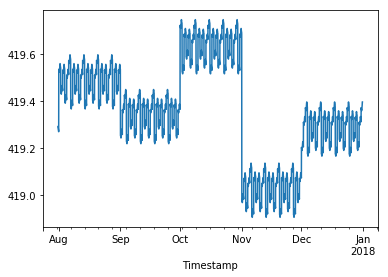

In [131]:
y_pred.plot()

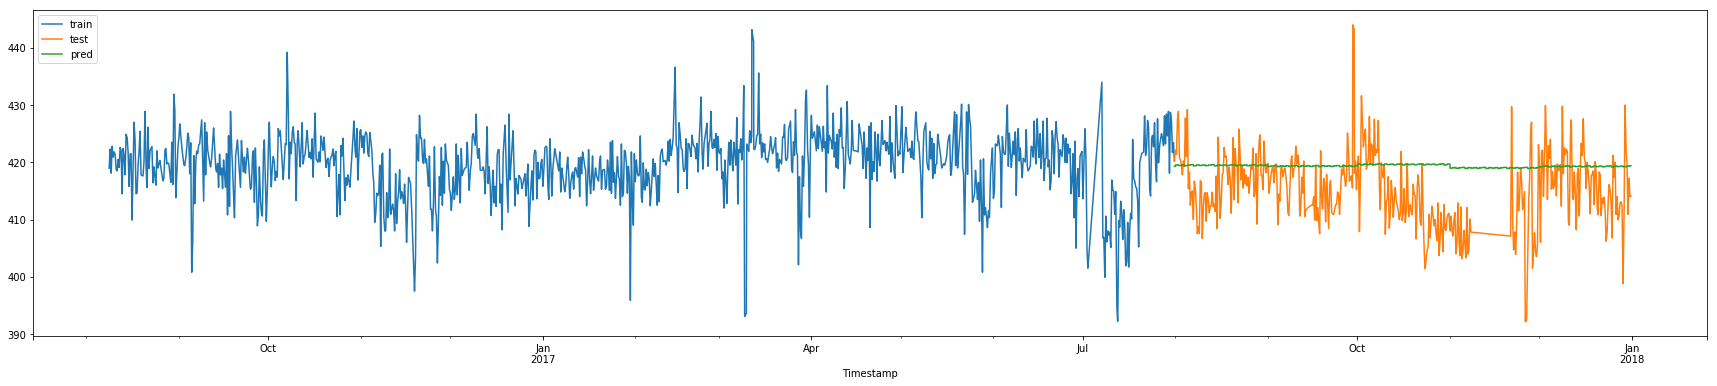

In [132]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [109]:
import numpy as np
def score_cv_rmse(mdl,X,y,tscv):
    rmse_tr = list()
    rmse_val = list()
    for tr_i, ho_i in tscv.split(X):
        mdl.fit(X[tr_i],y[tr_i])
        y_pred = mdl.predict(X[ho_i])
        y_pred_tr = mdl.predict(X[tr_i])
        rmse_val.append(np.sqrt(mean_squared_error(y[ho_i],y_pred)))
        rmse_tr.append(np.sqrt(mean_squared_error(y[tr_i],y_pred_tr)))
    rtr = np.mean(rmse_val)*0.7 + np.mean(rmse_tr)*0.3
    return rtr

In [120]:
def XGB_CV_REGS(
           reg_lambda,
           reg_alpha
          ):
    xgb = XGBRegressor(booster='gblinear',
                      max_depth=int(md),
                      min_child_weight=int(mw),
                      max_delta_step=int(md),
                      n_estimators=int(250),
                      colsample_bylevel= float(csl),
                      colsample_bytree= float(cst),
                       gamma=int(gm),
                       reg_lambda=float(reg_lambda),
                       reg_alpha=float(reg_alpha),
                        seed=NB_SEED,
                       n_jobs=-1
                      )
    tscv = TimeSeriesSplit(n_splits=5)
    scr = score_cv_rmse(xgb, x_tr.values, y_tr.values, tscv)
    return -scr

In [14]:
bds2={
    'reg_lambda':(0,1),
    'reg_alpha':(0,1)
}

In [122]:
xgbo_reg = BayesianOptimization(XGB_CV_REGS, bds2)

In [123]:
xgb_o = XGBRegressor(booster='gblinear',
                     eta
                      max_depth=int(md),
                      min_child_weight=int(mw),
                      max_delta_step=int(md),
                      n_estimators=int(1000),
                      colsample_bylevel= float(csl),
                      colsample_bytree= float(cst),
                       gamma=int(gm),
                     seed=NB_SEED,
                       n_jobs=-1
                    )

|   iter    |  target   | reg_alpha | reg_la... |
-------------------------------------------------
|  1        | -5.11     |  0.8758   |  0.947    |
|  2        | -5.11     |  0.9286   |  0.8295   |
|  3        | -5.11     |  0.6608   |  0.2356   |
|  4        | -4.993    |  0.0897   |  0.1723   |
|  5        | -25.2     |  0.5322   |  0.02089  |
|  6        | -5.101    |  0.3038   |  0.677    |
|  7        | -5.097    |  0.3612   |  0.2512   |
|  8        | -5.089    |  0.3665   |  0.1993   |
|  9        | -5.109    |  0.511    |  0.2906   |
|  10       | -29.53    |  0.6075   |  0.01603  |
|  11       | -5.11     |  0.6238   |  0.2912   |
|  12       | -5.11     |  0.8867   |  0.8813   |
|  13       | -5.11     |  0.9451   |  0.9075   |
|  14       | -5.11     |  0.6975   |  0.2787   |
|  15       | -5.023    |  0.1739   |  0.1862   |
|  16       | -5.075    |  0.2848   |  0.2048   |
|  17       | -5.049    |  0.1202   |  0.2431   |
|  18       | -5.106    |  0.4493   |  0.339    |


In [133]:
xgbo_reg.max

{'target': -4.992541375913451,
 'params': {'reg_alpha': 0.08969830192168904,
  'reg_lambda': 0.1723180484223219}}

In [15]:
optalpha = 0.08969830192168904
optlambda = 0.1723180484223219

In [138]:
xgb_o_2 = XGBRegressor(booster='gblinear',
                     eta=eta,
                      max_depth=int(md),
                      min_child_weight=int(mw),
                      max_delta_step=int(md),
                      n_estimators=int(1000),
                      colsample_bylevel= float(csl),
                      colsample_bytree= float(cst),
                       gamma=int(gm),
                     reg_lambda=optlambda,
                     reg_alpha=optalpha,
                     seed=NB_SEED,
                       n_jobs=-1
                    )

In [139]:
mdls = fit_model_cv(xgb_o_2,x_tr.values,y_tr.values)
y_pred_val = np.zeros((y_ts.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [140]:
y_pred = np.zeros((y_ts.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts.values)
y_pred = y_pred.mean(axis=1)

In [141]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [142]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 26.149963403808815 test: 57.22041801431732
RMSE train: 5.113703491972214 test: 7.564417889984484
MAE train: 3.766106047446367 test: 6.122910694177105
R2 train: 0.03242908385868082 test: -0.6039248565511943


In [143]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

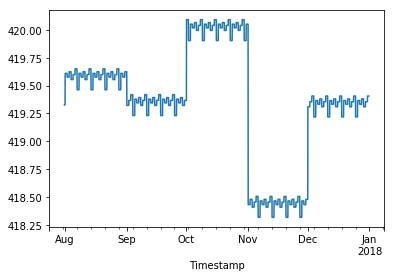

In [144]:
y_pred.plot()

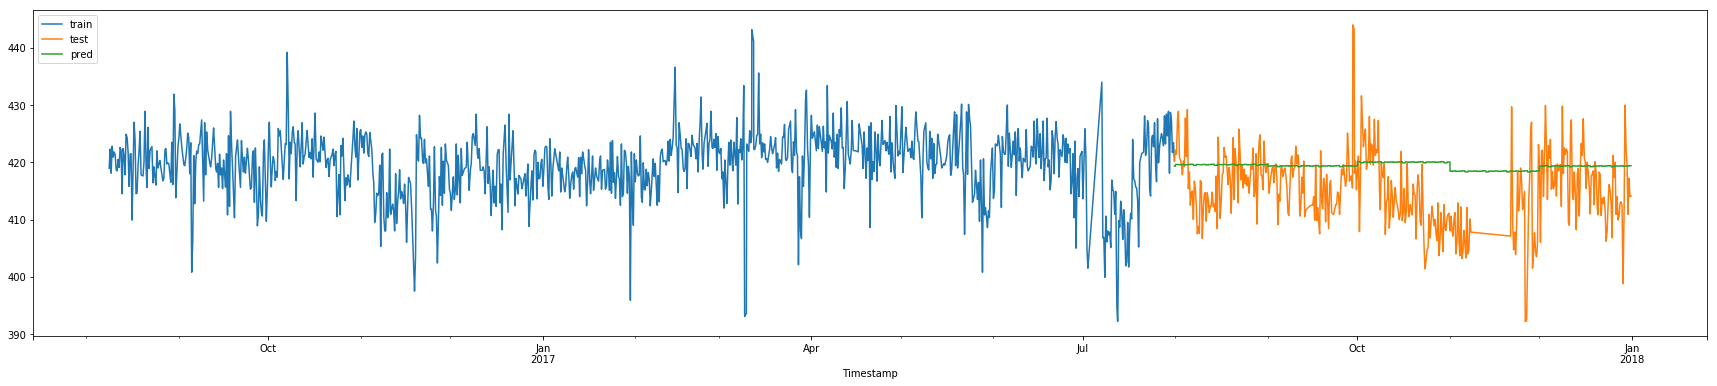

In [145]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [146]:
xgb_o_3 = XGBRegressor(booster='gblinear',
                     reg_lambda=optlambda,
                     reg_alpha=optalpha,
                     seed=NB_SEED,
                       n_jobs=-1
                    )

In [147]:
mdls = fit_model_cv(xgb_o_3,x_tr.values,y_tr.values)
y_pred_val = np.zeros((y_ts.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [148]:
y_pred = np.zeros((y_ts.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts.values)
y_pred = y_pred.mean(axis=1)

In [149]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [150]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 249.07613841182547 test: 59.152703956321886
RMSE train: 15.7821461915617 test: 7.6910795052659475
MAE train: 14.351474603732441 test: 5.684951982297554
R2 train: -8.21602924296903 test: -0.6580880654178283


In [151]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

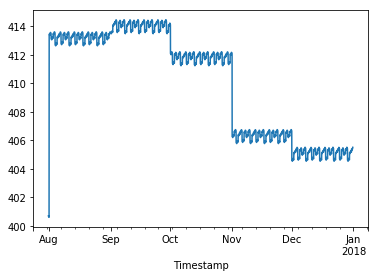

In [152]:
y_pred.plot()

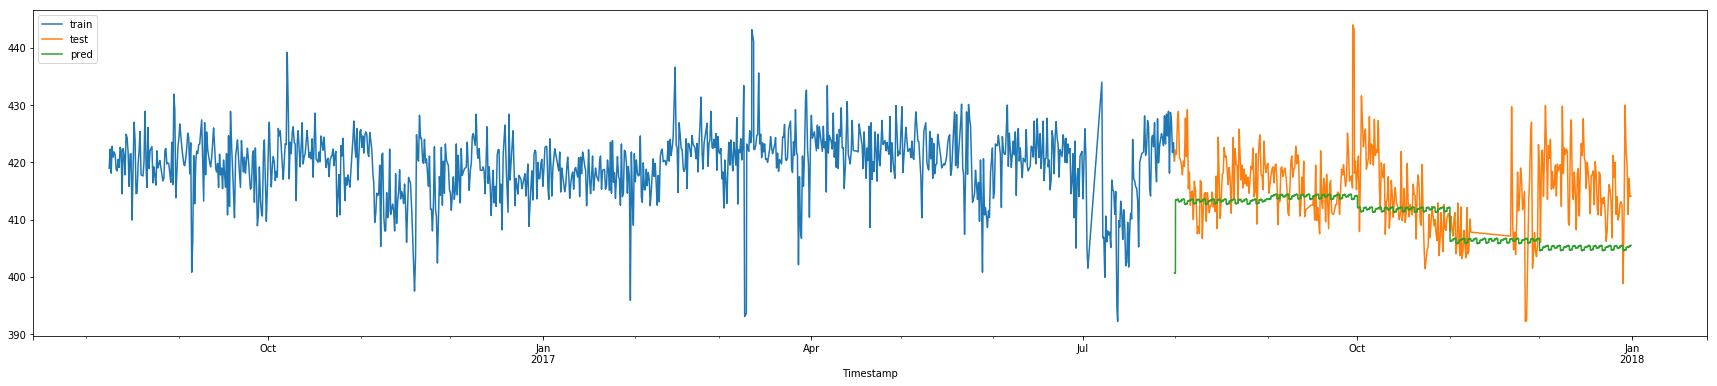

In [153]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [154]:
from mlxtend.regressor import StackingCVRegressor

In [164]:
stk = StackingCVRegressor(regressors=(xg,xgb_o,xgb_o_2,xgb_o_3),
                             meta_regressor=lr,
                             cv=tscv,
                             use_features_in_secondary=False)

In [165]:
mdls = fit_model_cv(stk,x_tr.values,y_tr.values)
y_pred_val = np.zeros((y_ts.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [166]:
y_pred = np.zeros((y_ts.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts.values)
y_pred = y_pred.mean(axis=1)

In [167]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [168]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 27.12867269742295 test: 57.25466889774974
RMSE train: 5.208519242301304 test: 7.5666814983683395
MAE train: 3.903026289990482 test: 6.0631353751759605
R2 train: -0.0037839935072447872 test: -0.6048849306856117


In [169]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

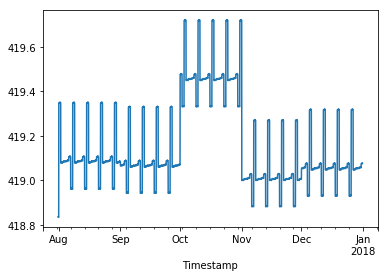

In [170]:
y_pred.plot()

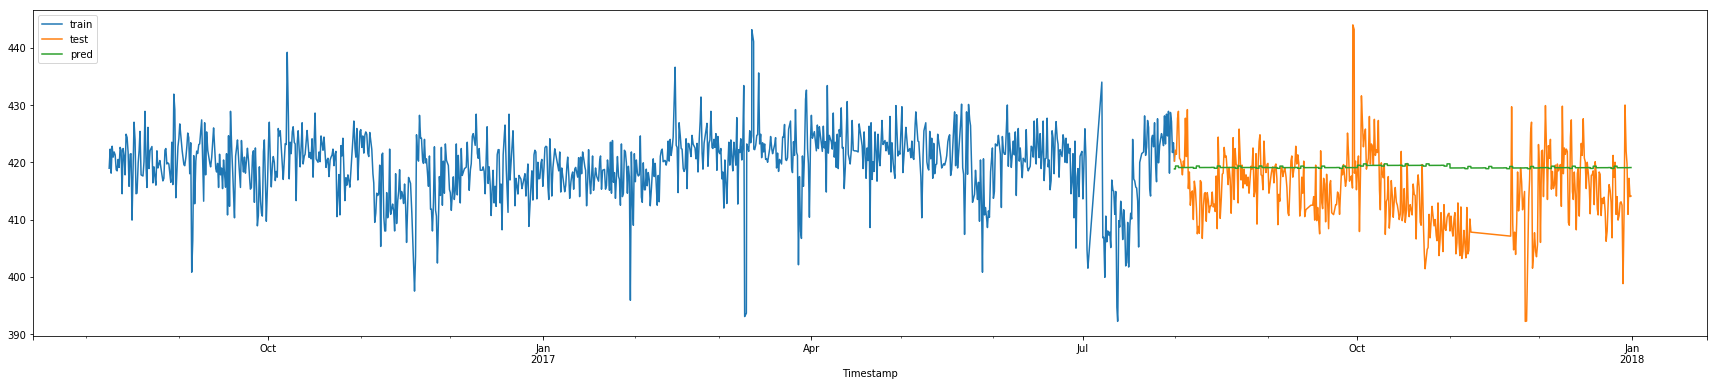

In [171]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [172]:
stk2 = StackingCVRegressor(regressors=(xg,xg_t),
                             meta_regressor=lr,
                             cv=tscv,
                             use_features_in_secondary=False)

In [173]:
mdls = fit_model_cv(stk,x_tr.values,y_tr.values)
y_pred_val = np.zeros((y_ts.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [174]:
y_pred = np.zeros((y_ts.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts.values)
y_pred = y_pred.mean(axis=1)

In [175]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [180]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 27.08700082203288 test: 57.212019521827095
RMSE train: 5.204517347654139 test: 7.56386273816673
MAE train: 3.8917556322799878 test: 6.068568963114336
R2 train: -0.0022420986286224576 test: -0.603689441443614


In [177]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

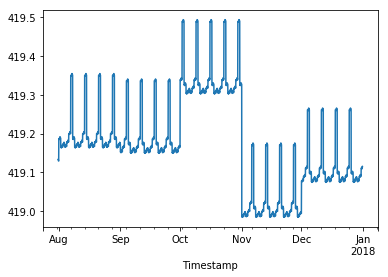

In [178]:
y_pred.plot()

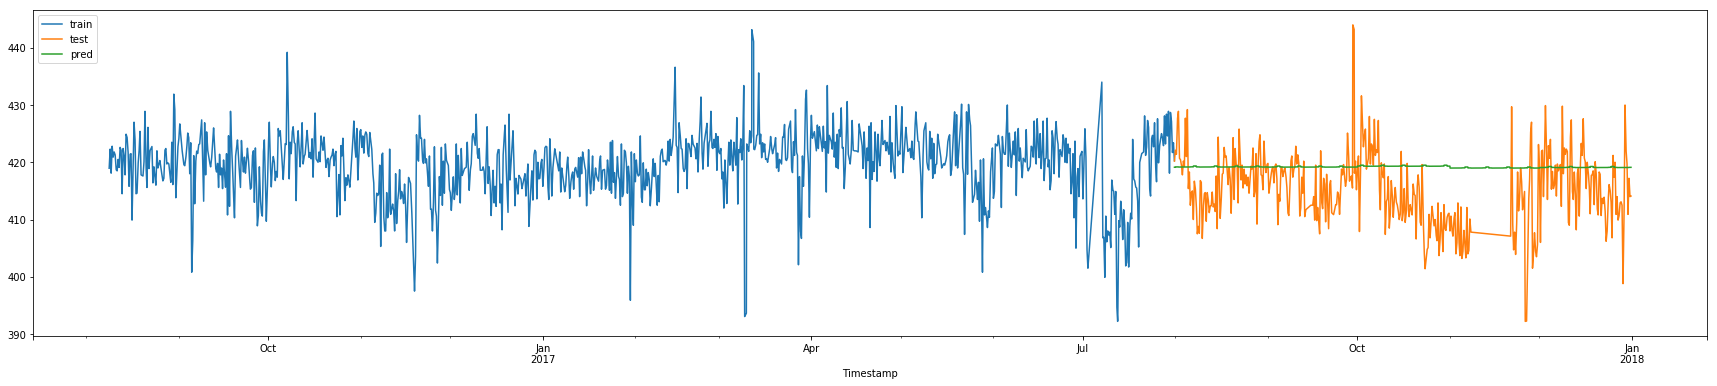

In [179]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [16]:
opt_params = xg.get_params()

In [24]:
opt_params['reg_lambda'] = optlambda
opt_params['reg_alpha'] = optalpha
print(opt_params)

{'base_score': 0.5, 'booster': 'gblinear', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0.08969830192168904, 'reg_lambda': 0.1723180484223219, 'scale_pos_weight': 1, 'seed': 123123, 'silent': True, 'subsample': 1, 'eta': 0.001}


In [23]:
XGBRegressor().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [52]:
xg_2 = XGBRegressor(#reg_lambda=optlambda,
                   reg_alpha=optalpha,
                   booster="gblinear",
                   n_jobs=-1,
                   seed=NB_SEED)


In [53]:
del mdls;gc.collect()

12

In [54]:
mdls = fit_model_cv(xg_2,x_tr.values,y_tr.values)

In [55]:
y_pred_val = np.zeros((y_ts.shape[0],len(mdls)))
y_pred_tr = np.zeros((y_tr.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred_val[:,i]= m.predict(x_ts.values)
    y_pred_tr[:,i] = m.predict(x_tr.values)
y_pred_val = y_pred_val.mean(axis=1)
y_pred_tr = y_pred_tr.mean(axis=1)

In [56]:
y_pred = np.zeros((y_ts.shape[0],len(mdls)))
for i, m in enumerate(mdls):
    y_pred[:,i]= m.predict(x_ts.values)
y_pred = y_pred.mean(axis=1)

In [57]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [58]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 27.846471716989875 test: 52.294750800213635
RMSE train: 5.276975622171271 test: 7.231510962462384
MAE train: 4.025373273466445 test: 5.781325811738904
R2 train: -0.03034316853333885 test: -0.46585525912491565


In [59]:
y_pred = pd.Series(data=y_pred, index=y_ts.index)

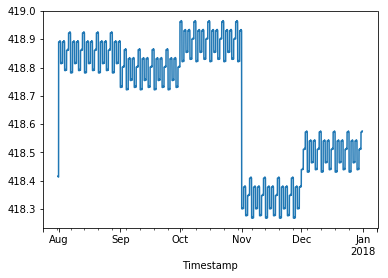

In [60]:
y_pred.plot()

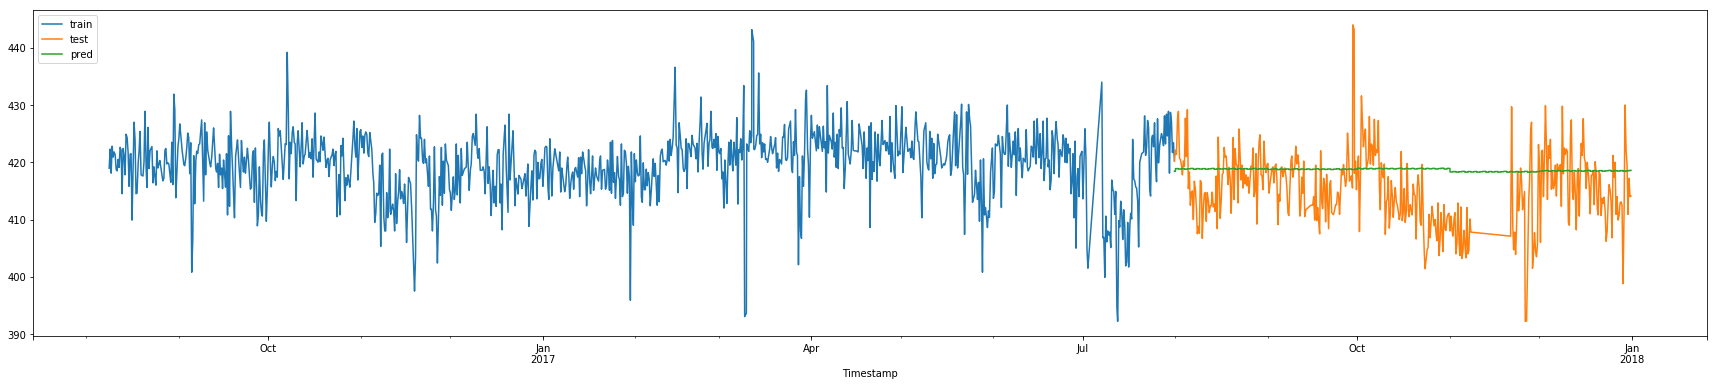

In [61]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')